<h2>Import bibliotek</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h2>Zadanie</h2>

Wczytanie zbioru danych populacji

In [2]:
# Read population data
population_data = pd.io.parsers.read_csv("things/population.dat", header = None, names = ['year', 'population'])

population_data

,year,population
0,1900,76212168
1,1910,92228496
2,1920,106021537
3,1930,123202624
4,1940,132164569
5,1950,151325798
6,1960,179323175
7,1970,203302031
8,1980,226542199
9,1990,248709873


Definicja zbiorów funkcji bazowych

In [3]:
# 1st base function
def base_function_1(j, t):
    return t ** (j-1)

# 2nd base function
def base_function_2(j, t):
    return (t-1900) ** (j-1)

# 3rd base function
def base_function_3(j, t):
    return (t-1940) ** (j-1)

# 4th base function
def base_function_4(j, t):
    return ((t-1940) / 40) ** (j-1)

<h3>a) Utworzenie macierzy Vandermonde'a dla danych zbiorów funkcji</h3>

In [4]:
# function returning the Vandermonde matrix for given set of functions
def create_vandermonde_matrix(function, points):
    return function(np.array(range(1,len(points)+1))[:,np.newaxis], points[:,0]).T

# create vandermonde matrices for base function sets
vandermonde1 = create_vandermonde_matrix(base_function_1, np.float64(population_data[population_data['year'] <= 1980].values))
vandermonde2 = create_vandermonde_matrix(base_function_2, np.float64(population_data[population_data['year'] <= 1980].values))
vandermonde3 = create_vandermonde_matrix(base_function_3, np.float64(population_data[population_data['year'] <= 1980].values))
vandermonde4 = create_vandermonde_matrix(base_function_4, np.float64(population_data[population_data['year'] <= 1980].values))

<h3>b) Współczynniki uwarunkowania macierzy Vandermonde'a</h3>

In [5]:
# calculate condition number for vandermonde matrices
cond1 = np.linalg.cond(vandermonde1)
cond2 = np.linalg.cond(vandermonde2)
cond3 = np.linalg.cond(vandermonde3)
cond4 = np.linalg.cond(vandermonde4)

# print out the condition numbers
print(f"Współczynnik uwarunkowania dla zbiorów funkcji 1: {"{:.3e}".format(cond1)}")
print(f"Współczynnik uwarunkowania dla zbiorów funkcji 2: {"{:.3e}".format(cond2)}")
print(f"Współczynnik uwarunkowania dla zbiorów funkcji 3: {"{:.3e}".format(cond3)}")
print(f"Współczynnik uwarunkowania dla zbiorów funkcji 4: {"{:.3e}".format(cond4)}")

Współczynnik uwarunkowania dla zbiorów funkcji 1: 3.983e+36
Współczynnik uwarunkowania dla zbiorów funkcji 2: 6.307e+15
Współczynnik uwarunkowania dla zbiorów funkcji 3: 9.316e+12
Współczynnik uwarunkowania dla zbiorów funkcji 4: 1.605e+03


<h3>c) Wielomian interpolacyjny dla najlepiej uwarunkowanej bazy</h3>

Współczynniki wielomianu interpolacyjnego

In [6]:
# solve matrix equation for coefficients
coefficients = np.linalg.solve(vandermonde4, population_data[population_data['year'] <= 1980]['population'])

Schemat Hornera do obliczania wartości wielomianu

In [7]:
# calculate the value of polynomial using Horner's method
def horner_method(coefficients, x):
    result = 0
    for coefficient in reversed(coefficients):
        result = x * result + coefficient
    return result

Narysowanie wielomianu interpolacyjnego

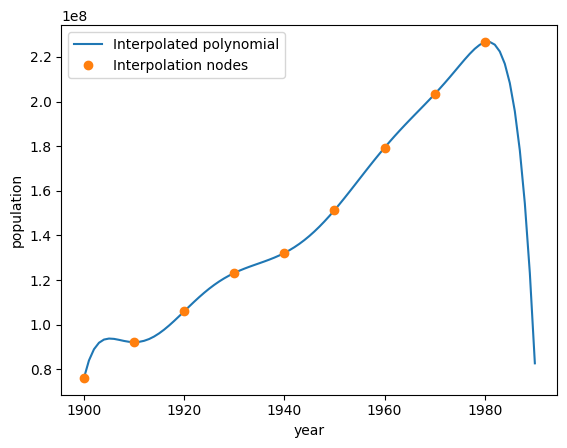

In [8]:
# define x and y values
xs = np.arange(1900, 1991)
ys_vandermonde = horner_method(coefficients, base_function_4(2, xs))
# add plot of interpolated polynomial and points 
plt.plot(xs, ys_vandermonde, label="Interpolated polynomial")
plt.plot(
    population_data[population_data['year'] <= 1980]['year'],
    population_data[population_data['year'] <= 1980]['population'],
    marker='o',
    linestyle='',
    label="Interpolation nodes"
)
# add axes labels
plt.xlabel("year")
plt.ylabel("population")
# show with legend
plt.legend()
plt.show()

<h3>d) Ekstrapolacja wielomianu do roku 1990</h3>

In [9]:
# predicted value
predicted_1990 = horner_method(coefficients, base_function_4(2, 1990))
# actual value
actual_1990 = population_data['population'][population_data['year'] == 1990].values[0]

# compare predicted and actual values
print(f"Wartość przewidywana: {"{:.3e}".format(predicted_1990)}")
print(f"Wartość prawdziwa: {"{:.3e}".format(actual_1990)}")
print(f"Błąd względny: {"{:.4f}".format(abs(actual_1990-predicted_1990)/actual_1990)}")

Wartość przewidywana: 8.275e+07
Wartość prawdziwa: 2.487e+08
Błąd względny: 0.6673


<h3>e) Interpolacja Lagrange'a</h3>

Funkcje obliczające wartości wielomianu Lagrange'a

In [10]:
# calculate lagrange numerator
def lagrange_numerator(points, index, x):
    xs = points[:,0]
    factors = x - xs[xs != xs[index]]
    return np.prod(factors)

# calculate lagrange denominator
def lagrange_denominator(points, index):
    xs = points[:,0]
    factors = xs[index] - xs[xs != xs[index]]
    return np.prod(factors)

# calculate lagrange polynomial values (pass denominators to avoid unnecessert recomputation)
def lagrange_value(points, x, denominators):
    result = 0
    for index, point in enumerate(points):
        result += point[1] * lagrange_numerator(points, index, x) / denominators[index]
    return result

Narysowanie wielomianu Lagrange'a

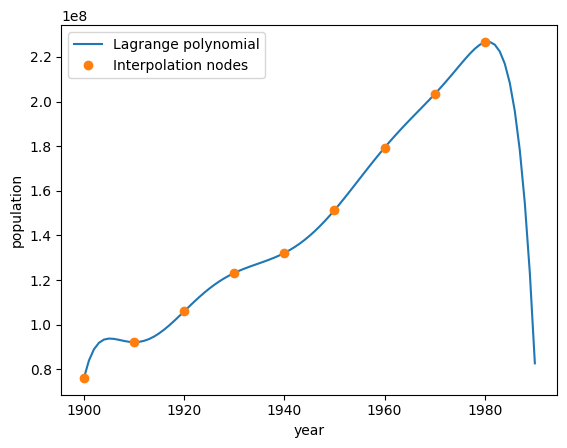

In [11]:
# define x and y values
points = np.float64(population_data[population_data['year'] <= 1980].values)
denominators = [lagrange_denominator(points, index) for index in range(len(points))]
ys_lagrange = [lagrange_value(points, x, denominators) for x in xs]

# add plot of interpolated polynomial and points 
plt.plot(xs, ys_lagrange, label="Lagrange polynomial")
plt.plot(
    population_data[population_data['year'] <= 1980]['year'],
    population_data[population_data['year'] <= 1980]['population'],
    marker='o',
    linestyle='',
    label="Interpolation nodes"
)
# add axes labels
plt.xlabel("year")
plt.ylabel("population")
# show with legend
plt.legend()
plt.show()

Porównanie wyliczonych wartości wielomianu Lagrange'a i wielomianu interpolowanego z macierzy Vandermonde'a

In [12]:
# compare calculated values of polynomial
print(f"Wartości wielomianów są identyczne w granicy błędu: {np.allclose(ys_vandermonde, ys_lagrange)}")

Wartości wielomianów są identyczne w granicy błędu: True


<h3>f) Interpolacja Newtona</h3>

Funkcje obliczające wartości wielomianu Newtona

In [13]:
# calculate divided differences for newton polynomial
def divided_differences(points):
    div_diffs = np.array(points[:,1], copy=True)
    n = len(points)
    for i in range(1, n):
        div_diffs[i : n] = (div_diffs[i : n] - div_diffs[i - 1]) / (points[:,0][i : n] - points[:,0][i - 1])
    return div_diffs

# calculate the value of newton polynomial using horner's method (pass divided differences to avoid unnecessert recomputation)
def newton_horner(points, x, div_diffs):
    result = 0
    n = len(points)
    for i, div_diff in enumerate(reversed(div_diffs)):
        result = (x - points[:,0][n - i - 1]) * result + div_diff
    return result

Narysowanie wielomianu Newtona

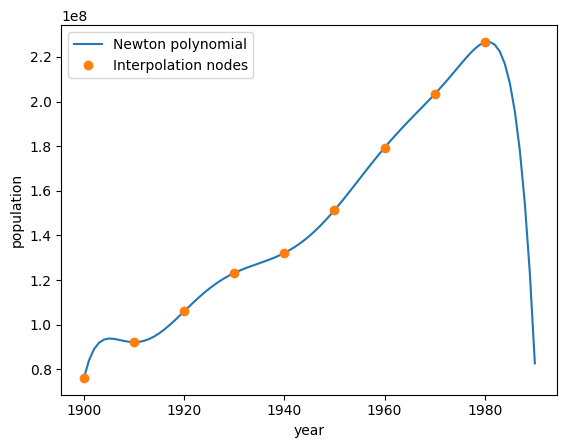

In [14]:
# define x and y values
points = np.float64(population_data[population_data['year'] <= 1980].values)
div_diffs = divided_differences(points)
ys_newton = [newton_horner(points, x, div_diffs) for x in xs]

# add plot of interpolated polynomial and points 
plt.plot(xs, ys_newton, label="Newton polynomial")
plt.plot(
    population_data[population_data['year'] <= 1980]['year'],
    population_data[population_data['year'] <= 1980]['population'],
    marker='o',
    linestyle='',
    label="Interpolation nodes"
)
# add axes labels
plt.xlabel("year")
plt.ylabel("population")
# show with legend
plt.legend()
plt.show()

Porównanie wyliczonych wartości wielomianu Newtona i wielomianu interpolowanego z macierzy Vandermonde'a

In [15]:
# compare calculated values of polynomial
print(f"Wartości wielomianów są identyczne w granicy błędu: {np.allclose(ys_vandermonde, ys_newton)}")

Wartości wielomianów są identyczne w granicy błędu: True


<h3>g) Interpolacja przy zaokrągleniu do miliona</h3>

Zaokrąglenie danych do miliona

In [16]:
# data rounded to a million
population_data_rounded = pd.DataFrame(data=population_data, copy=True)
population_data_rounded['population'] = population_data_rounded['population'].round(-6)
population_data_rounded

,year,population
0,1900,76000000
1,1910,92000000
2,1920,106000000
3,1930,123000000
4,1940,132000000
5,1950,151000000
6,1960,179000000
7,1970,203000000
8,1980,227000000
9,1990,249000000


Współczynniki wielomianu interpolacyjnego

In [17]:
# solve matrix equation for coefficients
coefficients_rounded = np.linalg.solve(vandermonde4, population_data_rounded[population_data_rounded['year'] <= 1980]['population'])

Narysowanie wielomianu interpolacyjnego

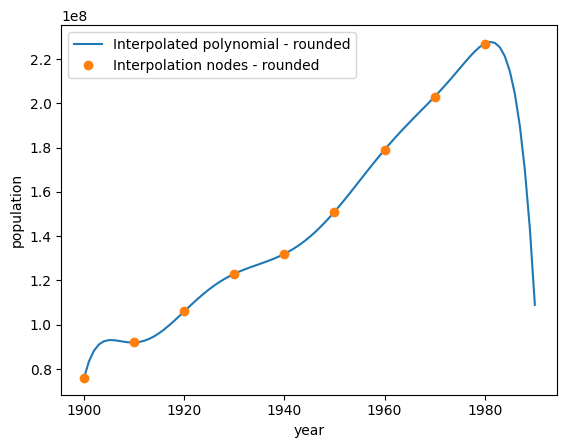

In [18]:
# define x and y values
xs = np.arange(1900, 1991)
ys_rounded = horner_method(coefficients_rounded, base_function_4(2, xs))
# add plot of interpolated polynomial and points 
plt.plot(xs, ys_rounded, label="Interpolated polynomial - rounded")
plt.plot(
    population_data_rounded[population_data_rounded['year'] <= 1980]['year'],
    population_data_rounded[population_data_rounded['year'] <= 1980]['population'],
    marker='o',
    linestyle='',
    label="Interpolation nodes - rounded"
)
# add axes labels
plt.xlabel("year")
plt.ylabel("population")
# show with legend
plt.legend()
plt.show()

Porównanie wyznaczonych współczynników

In [19]:
comparison = pd.DataFrame({
    'coefficients': coefficients,
    'coefficients - rounded': coefficients_rounded,
    'relative difference': (coefficients - coefficients_rounded) / coefficients
})
comparison

,coefficients,coefficients - rounded,relative difference
0,1.321646e+08,1.320000e+08,0.001245
1,4.613077e+07,4.595714e+07,0.003764
2,1.027163e+08,1.001413e+08,0.025069
3,1.825271e+08,1.811111e+08,0.007758
4,-3.746147e+08,-3.567556e+08,0.047673
5,-3.426685e+08,-3.384889e+08,0.012197
6,6.062912e+08,5.703111e+08,0.059345
7,1.891756e+08,1.869206e+08,0.011920
8,-3.151802e+08,-2.941968e+08,0.066576


Ekstrapolacja wielomianu do roku 1990

In [20]:
# predicted value
predicted_1990 = horner_method(coefficients_rounded, base_function_4(2, 1990))
# actual value
actual_1990 = population_data['population'][population_data['year'] == 1990].values[0]

# compare predicted and actual values
print(f"Wartość przewidywana: {"{:.3e}".format(predicted_1990)}")
print(f"Wartość prawdziwa: {"{:.3e}".format(actual_1990)}")
print(f"Błąd względny: {"{:.4f}".format(abs(actual_1990-predicted_1990)/actual_1990)}")

Wartość przewidywana: 1.090e+08
Wartość prawdziwa: 2.487e+08
Błąd względny: 0.5617
